## Import PuLP package

In [2]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
# pulp.pulpTestAll()

## Define Constant

割引クーポンによるマーケティングキャンペーンの最適化
送付率下限値最大化モデルとする。

- customers.csv             :顧客情報
- visit_probability.csv     :キャンペーン毎の顧客来店確率
- キャンペーンの種類は1.メール、2.メール＋1000円割引クーポン、3.メール＋2000円割引クーポンの3種類

In [4]:
customer_df = pd.read_csv('customers.csv')
visit_prob_df = pd.read_csv('visit_probability.csv')

In [5]:
customer_df.head()

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


In [6]:
customer_df.shape

(5000, 3)

In [7]:
customer_df.apply(set)

customer_id    {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
age_cat                     {age50~, age35~49, age~19, age20~34}
freq_cat                           {freq0, freq2, freq1, freq3~}
dtype: object

In [8]:
visit_prob_df.head()

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37


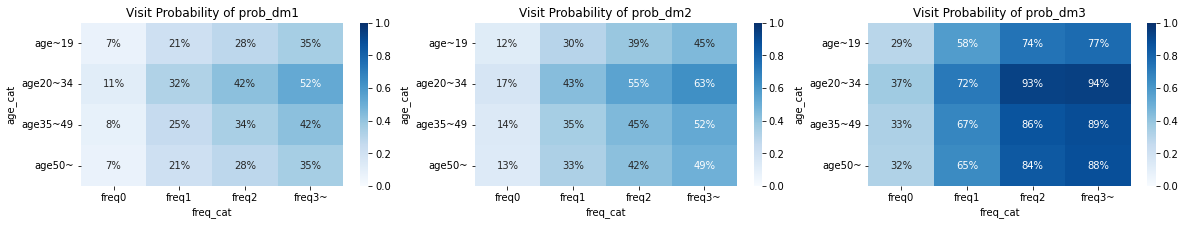

In [9]:
fig, axes = plt.subplots(1,3, figsize=(20,3))
for i, prob in enumerate(['prob_dm1', 'prob_dm2', 'prob_dm3']):
    visit_prob_pivot = pd.pivot_table(visit_prob_df, prob, index='age_cat', columns=['freq_cat'] )
    visit_prob_pivot = visit_prob_pivot.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(visit_prob_pivot, ax=axes[i], vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues')
    axes[i].set_title(f'Visit Probability of {prob}')
plt.show()

In [10]:
#顧客のリスト
I = customer_df['customer_id'].to_list()
#クーポンのリスト
M = [ 1, 2, 3]

In [11]:
cus_prob_df = pd.merge(customer_df, visit_prob_df, on=['age_cat', 'freq_cat'])
cus_prob_df.head()

,customer_id,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,1,age20~34,freq2,7,0.42,0.55,0.93
1,199,age20~34,freq2,7,0.42,0.55,0.93
2,200,age20~34,freq2,7,0.42,0.55,0.93
3,255,age20~34,freq2,7,0.42,0.55,0.93
4,269,age20~34,freq2,7,0.42,0.55,0.93


In [12]:
cus_prob_df.shape

(5000, 7)

In [13]:
#セグメントのリスト
S = visit_prob_df['segment_id'].to_list()
S

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

## Create Variable

セグメントsをキャンペーンmに割り当てる確率0-1

In [14]:
# 0-1整数計画問題の場合 binary

xsm={}
for s in S:
    for m in M:
        xsm[s,m] = pulp.LpVariable(f'xsm({s},{m})', lowBound=0, upBound=1, cat='Continuous')

In [15]:
xsm[1,1]

xsm(1,1)

In [16]:
len(xsm)

48

- 各セグメントへのそれぞれのパターンのダイレクトメールの送付率の下限値

In [17]:
y = pulp.LpVariable(name='y', lowBound=0, upBound=1, cat='Continuous')

In [18]:
cust_prob_ver_df = cus_prob_df.rename(columns={'prob_dm1':1 , 'prob_dm2':2, 'prob_dm3':3}).melt(id_vars=['customer_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
cust_prob_ver_df.head()

,customer_id,dm,prob
0,1,1,0.42
1,199,1,0.42
2,200,1,0.42
3,255,1,0.42
4,269,1,0.42


In [19]:
prob_ver_df = visit_prob_df.rename(columns={'prob_dm1':1 , 'prob_dm2':2, 'prob_dm3':3}).melt(id_vars=['segment_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
prob_ver_df.head()

,segment_id,dm,prob
0,1,1,0.07
1,2,1,0.21
2,3,1,0.28
3,4,1,0.35
4,5,1,0.11


In [20]:
prob_ver_df.shape

(48, 3)

In [21]:
Psm = prob_ver_df.set_index(['segment_id', 'dm'])['prob'].to_dict()
Psm[1,1]

0.07

## Create Model

- `LpProblem('name', sense=LpMinimize or LpMaximize)

In [22]:
prob = pulp.LpProblem('DiscountCouponProblem3', pulp.LpMaximize)

## Create Constraint

In [23]:
# (2) 各セグメントに送るダイレクトメールはいずれか１つ/送付確率の合計が1
for s in S:
    prob += pulp.lpSum([xsm[s, m] for m in M]) == 1

In [24]:
# クーポン金額
Cm = { 1: 0, 2:1000, 3:2000}

In [25]:
Ns = cus_prob_df.groupby(['segment_id'])['customer_id'].count().to_dict()
Ns

{1: 200,
 2: 150,
 3: 50,
 4: 100,
 5: 600,
 6: 450,
 7: 150,
 8: 300,
 9: 800,
 10: 600,
 11: 200,
 12: 400,
 13: 400,
 14: 300,
 15: 100,
 16: 200}

In [26]:
N = 0
for key, val in Ns.items():
    N += val
print(N)

5000


In [27]:
# (4) 顧客の消費する費用の期待値の合計値は100万円以下
prob += pulp.lpSum(xsm[s, m] * Cm[m] * Psm[s, m] * Ns[s] for s in S for m in [2,3]) <= 1000000

In [28]:
# (5) セグメントに属する会員数の10%以上に送付
for s in S:
    for m in M:
        prob += xsm[s,m] >= y

## Create Target function

In [29]:
# 送付率の下限値を最大化

prob += y

## Exec Solver

- Default solver is CBC. You can use GLPK if installed.

In [30]:
time_start = time.time()
status = prob.solve()
time_stop = time.time()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/norihito/workspace/optimization-problems/.venv/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/288c46ce386f4a5596b3c3b2945492da-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/288c46ce386f4a5596b3c3b2945492da-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 248 RHS
At line 314 BOUNDS
At line 364 ENDATA
Problem MODEL has 65 rows, 49 columns and 176 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 49 (-16) rows, 33 (-16) columns and 144 (-32) elements
Perturbing problem by 0.001% of 0.62819912 - largest nonzero change 0.00094529304 ( 0.15047666%) - largest zero change 9.6171668e-05
0  Obj -0 Dual inf 0.62725282 (1)
31  Obj 0.13116342 Primal inf 0.17027776 (2)
33  Obj 0.13040049
Optimal - objective value 0.13125943
After Postsolve, objective 0.

## Check status

- You can check the status by `LpStatus` which shows 
    {0: 'Not Solved', 1: 'Optimal', -1:'Infeasible', -2: 'Unbounded', -3: 'Undefined'}

In [31]:
pulp.LpStatus

{0: 'Not Solved',
 1: 'Optimal',
 -1: 'Infeasible',
 -2: 'Unbounded',
 -3: 'Undefined'}

In [32]:
pulp.LpStatus[prob.status]
# pulp.LpStatus[status]

'Optimal'

## Result 

In [33]:
print(f'目的関数値: {prob.objective.value():.4}')
print(f'計算時間:{(time_stop-time_start):.3}(秒)')

目的関数値: 0.1313
計算時間:0.344(秒)


## Verification

In [34]:
send_dm_df = pd.DataFrame([[xsm[s,m].value() for m in M] for s in S], columns=['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3'])
send_dm_df

,send_prob_dm1,send_prob_dm2,send_prob_dm3
0,0.737481,0.131259,0.131259
1,0.737481,0.131259,0.131259
2,0.737481,0.131259,0.131259
3,0.737481,0.131259,0.131259
4,0.737481,0.131259,0.131259
5,0.737481,0.131259,0.131259
6,0.737481,0.131259,0.131259
7,0.737481,0.131259,0.131259
8,0.737481,0.131259,0.131259
9,0.737481,0.131259,0.131259


In [35]:
seg_send_df = pd.concat([visit_prob_df[['segment_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
seg_send_df

,segment_id,age_cat,freq_cat,send_prob_dm1,send_prob_dm2,send_prob_dm3
0,1,age~19,freq0,0.737481,0.131259,0.131259
1,2,age~19,freq1,0.737481,0.131259,0.131259
2,3,age~19,freq2,0.737481,0.131259,0.131259
3,4,age~19,freq3~,0.737481,0.131259,0.131259
4,5,age20~34,freq0,0.737481,0.131259,0.131259
5,6,age20~34,freq1,0.737481,0.131259,0.131259
6,7,age20~34,freq2,0.737481,0.131259,0.131259
7,8,age20~34,freq3~,0.737481,0.131259,0.131259
8,9,age35~49,freq0,0.737481,0.131259,0.131259
9,10,age35~49,freq1,0.737481,0.131259,0.131259


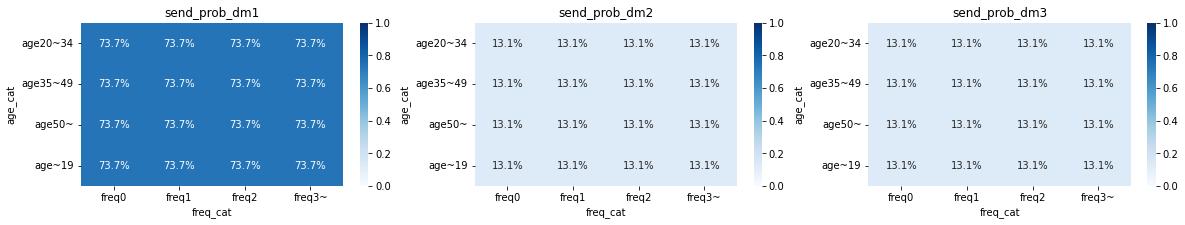

In [36]:
fig, axes = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3']):
    seg_send_pivot_df = pd.pivot_table(seg_send_df, ptn, index='age_cat', columns=['freq_cat'], aggfunc='mean')
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', ax=axes[i], vmin=0, vmax=1)
    axes[i].set_title(f'{ptn}')
plt.show()

In [37]:
seg_send_df['num_cust'] = seg_send_df['segment_id'].apply(lambda x: Ns[x])
seg_send_df['send_num_dm1'] = seg_send_df['num_cust'] * seg_send_df['send_prob_dm1']
seg_send_df['send_num_dm2'] = seg_send_df['num_cust'] * seg_send_df['send_prob_dm2']
seg_send_df['send_num_dm3'] = seg_send_df['num_cust'] * seg_send_df['send_prob_dm3']
seg_send_df.head()

,segment_id,age_cat,freq_cat,send_prob_dm1,send_prob_dm2,send_prob_dm3,num_cust,send_num_dm1,send_num_dm2,send_num_dm3
0,1,age~19,freq0,0.737481,0.131259,0.131259,200,147.496226,26.251886,26.251886
1,2,age~19,freq1,0.737481,0.131259,0.131259,150,110.622170,19.688915,19.688915
2,3,age~19,freq2,0.737481,0.131259,0.131259,50,36.874057,6.562972,6.562972
3,4,age~19,freq3~,0.737481,0.131259,0.131259,100,73.748113,13.125943,13.125943
4,5,age20~34,freq0,0.737481,0.131259,0.131259,600,442.488678,78.755658,78.755658


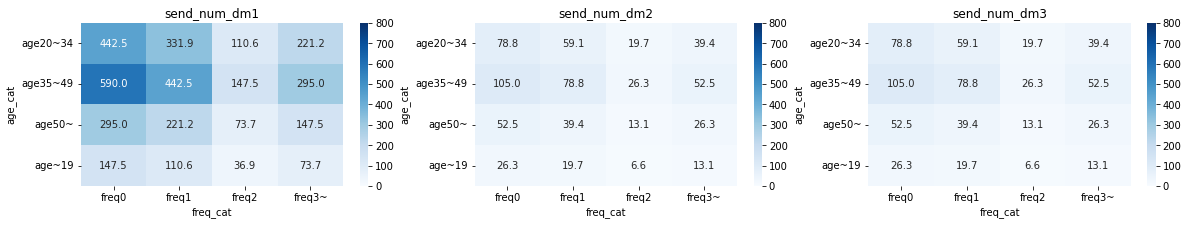

In [38]:
fig, axes = plt.subplots(1,3,figsize=(20,3))
for i, ptn in enumerate(['send_num_dm1', 'send_num_dm2', 'send_num_dm3']):
    seg_send_pivot_df = pd.pivot_table(seg_send_df, values=ptn, index='age_cat', columns=['freq_cat'])
    sns.heatmap(seg_send_pivot_df, vmin=0, vmax=800, cmap='Blues', ax=axes[i], fmt='.1f', annot=True)
    axes[i].set_title(f'{ptn}')
plt.show()